# Open Market Backtesting

### Imports

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
seaborn.set()
import wrds
import sys
sys.path.append('..')
import os

# Import Main Python Modules
from src.dataframe_construction import *
from src.a_estimation import *
from src.optimal_strategies import *
from src.backtest import *


### Backtesting

#### Setting up the data

In [2]:
daily = False
datapath='../data/'

if daily:
    d = 3000
    start_date='2013-01-01'
    filename='CRSP_2013_2018_daily_cleaned.h5'
    caps_table='dlyprevcap'
    returns_table='dlyret'
else:
    d = 2000
    start_date='1965-01-01'
    filename='CRSP_monthly_cleaned.h5'
    caps_table='mthprevcap'
    returns_table='mthret'

df = Data(d=d, start_date=start_date, datapath=datapath, filename=filename, caps_table=caps_table, returns_table=returns_table)

#### Estimating $a$

[ 0.          4.57170659  4.10682566  4.48206428  6.82392276 10.1983357
 10.22599897 13.33873013 14.16285065 14.77309787]


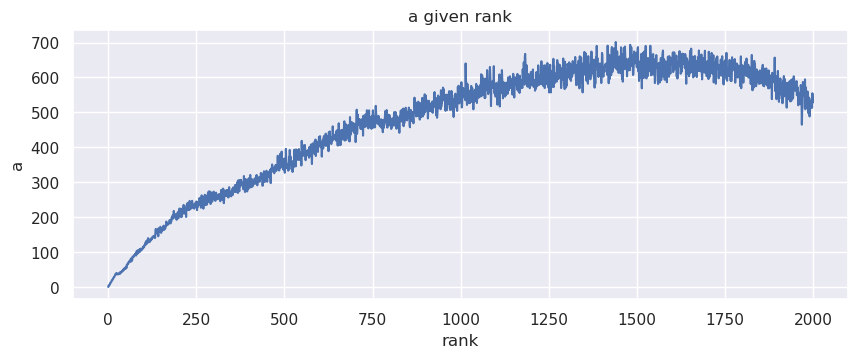

In [3]:
bar_a = compute_a_bar_direct_log(df.weights_by_rank)
print(bar_a[:10])
plot_a(bar_a)

#### Polynomial Fit

/home/pedro/miniconda3/envs/math_fin/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


[  1.13247615   3.00250852   4.81163221 ... 518.4467732  517.00758535
 515.51608537]
[  1.13247615   3.00250852   4.81163221 ... 518.4467732  517.00758535
 515.51608537]
[  0.           4.57170659   4.10682566 ... 513.27651005 554.75379112
 528.25857034]


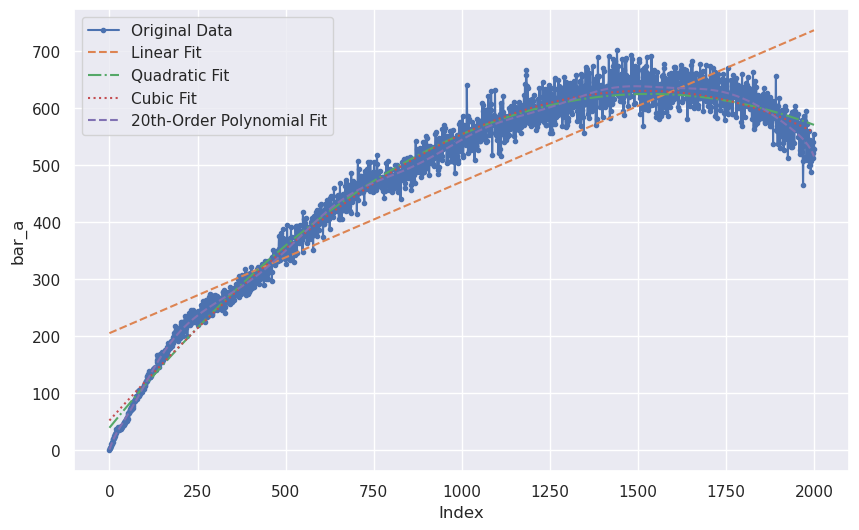

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Generate x-values (indices)
x_values = np.arange(len(bar_a))

# Fit a linear curve (degree = 1)
linear_coeffs = np.polyfit(x_values, bar_a, 1)
linear_fit = np.poly1d(linear_coeffs)
linear_smoothed = linear_fit(x_values)

# Fit a quadratic curve (degree = 2)
quad_coeffs = np.polyfit(x_values, bar_a, 2)
quad_fit = np.poly1d(quad_coeffs)
quad_smoothed = quad_fit(x_values)

# Fit a cubic curve (degree = 3)
cubic_coeffs = np.polyfit(x_values, bar_a, 3)
cubic_fit = np.poly1d(cubic_coeffs)
cubic_smoothed = cubic_fit(x_values)

# Fit a 10th-order polynomial curve (degree = 10)
k = 20
tenth_order_coeffs = np.polyfit(x_values, bar_a, k)
tenth_order_fit = np.poly1d(tenth_order_coeffs)
tenth_order_smoothed = tenth_order_fit(x_values)

# Plot the original data, linear fit, quadratic fit, cubic fit, and quartic fit
plt.figure(figsize=(10, 6))
plt.plot(x_values, bar_a, label='Original Data', marker='o', markersize=3)
plt.plot(x_values, linear_smoothed, label='Linear Fit', linestyle='--')
plt.plot(x_values, quad_smoothed, label='Quadratic Fit', linestyle='-.')
plt.plot(x_values, cubic_smoothed, label='Cubic Fit', linestyle=':')
plt.plot(x_values, tenth_order_smoothed, label=str(k)+'th-Order Polynomial Fit', linestyle='--')

plt.xlabel('Index')
plt.ylabel('bar_a')
plt.legend()
print(tenth_order_smoothed)
print(tenth_order_smoothed)
print(bar_a)
plt.show()


[1.13247615 3.00250852 4.81163221 6.5629705  8.25953132]
[0.         4.57170659 4.10682566 4.48206428 6.82392276]


/tmp/ipykernel_2070057/3443091466.py:1: RankWarning: Polyfit may be poorly conditioned
  smoothed_bar_a = smooth_time_series(bar_a, 'polynomial', 20)


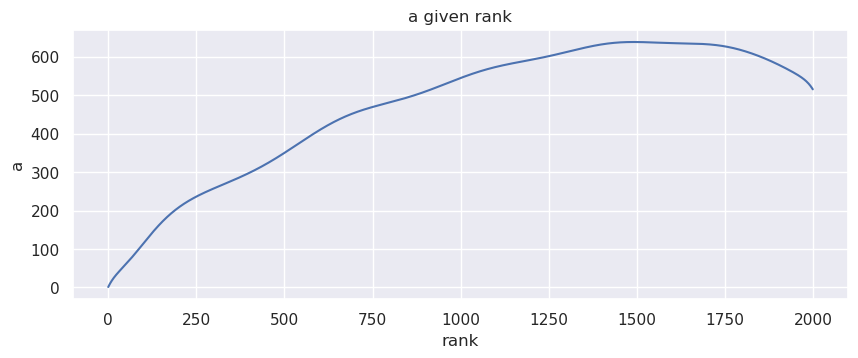

In [5]:
smoothed_bar_a = smooth_time_series(bar_a, 'polynomial', 20)
print(smoothed_bar_a[:5])
print(bar_a[:5])
plot_a(smoothed_bar_a)

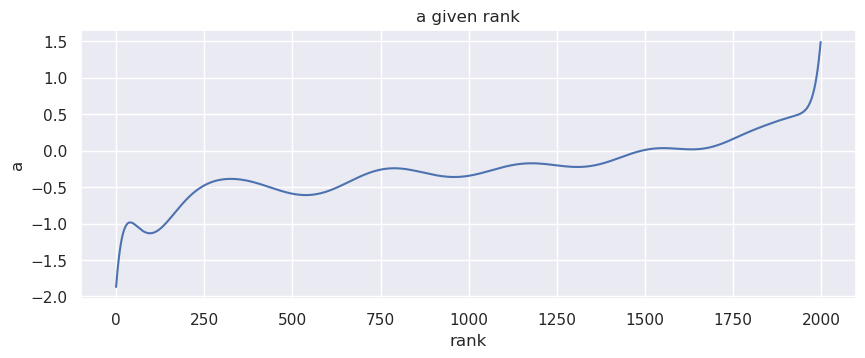

In [6]:
a = compute_a_given_a_bar(smoothed_bar_a)
plot_a(a[:-1])

[1.58626374 1.24520934 0.92377999 0.62125249 0.33692288]


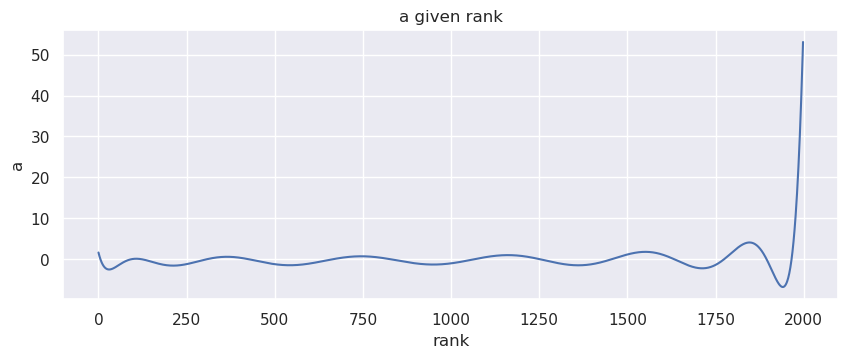

In [7]:
method = 'direct_log'
smooth_method = 'polynomial'
smooth_parameter = 14
smooth_a = False
a = estimate_a(df.weights_by_rank, smooth_method=smooth_method, smooth_parameter=smooth_parameter,  smooth_a=smooth_a)
print(a[:5])
plot_a(a[:-1])

#### Compute Optimal Strategy and Backtest

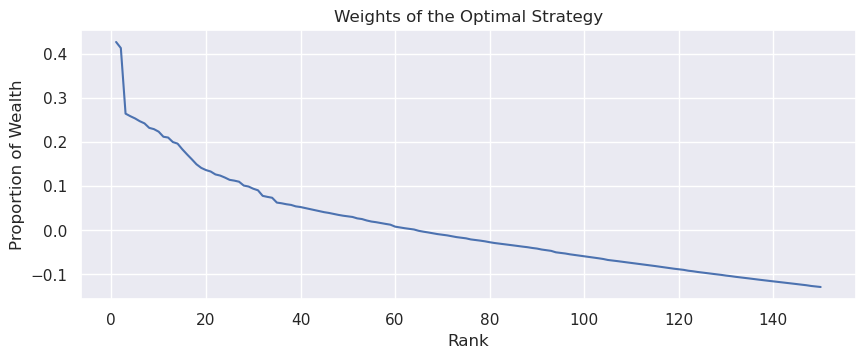

In [32]:
method = 'direct_log'
smooth_method = 'polynomial'
smooth_parameter = 2
smooth_a = False
a = estimate_a(df.weights_by_rank, smooth_method=smooth_method, smooth_parameter=smooth_parameter,  smooth_a=smooth_a)

setting = 'pure'
N = 150
plot_date = '2013-03-28'

strategy = compute_weights_optimal_open(setting=setting, N=N, a=a, weights_by_rank=df.weights_by_rank)
plot_strategy(strategy, plot_date)

The average return each month was 1.0063
The final cumulative interest in the period was 0.1034


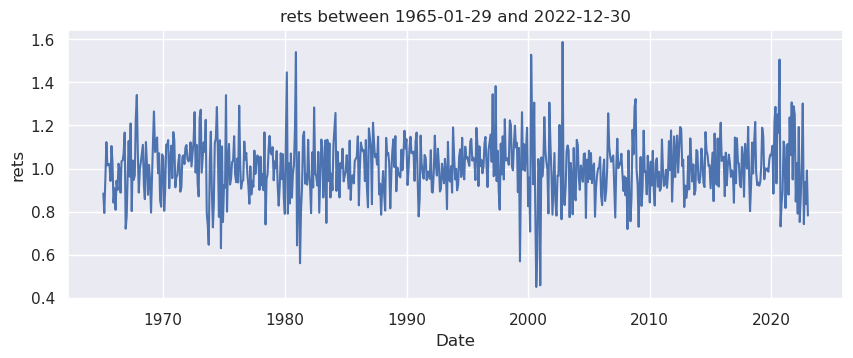

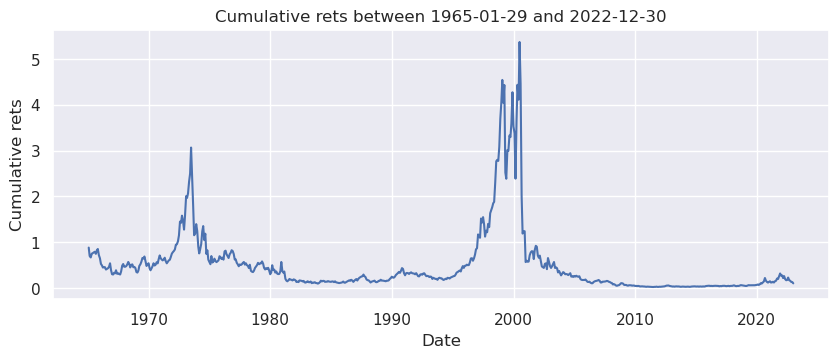

In [33]:
backtest = Backtest(strategy=strategy, weights_permno_by_rank=df.weights_permno_by_rank, returns_by_permno=df.returns_by_permno)
    
backtest.run()
print('The average return each month was',round(np.mean(backtest.rets), 4))
print('The final cumulative interest in the period was', round(np.mean(backtest.cumulative_rets[-1]), 4))
backtest.plot_rets()
backtest.plot_cumulative_rets()

#### HyperParameter Testing

In [80]:
Ns = list(range(200)) + list(range(200,500, 10)) + list(range(500,2000, 100))
print(len(Ns))
print(Ns)

245
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 

In [77]:
def plot_given_N(Ns, vector, m, folder, name):
    # Filter Ns and vector based on the m parameter
    Ns_filtered = [n for n in Ns if n <= m]
    vector_filtered = vector[:len(Ns_filtered)]

    plt.figure(figsize=(10, 5))
    plt.plot(Ns_filtered, vector_filtered, marker='o', linestyle='-', linewidth=2)
    plt.xlabel('N')
    plt.ylabel('Average Return')
    plt.title('Average Return for Different Ns')

    plt.savefig(f'{folder}{name}.png', dpi=300)

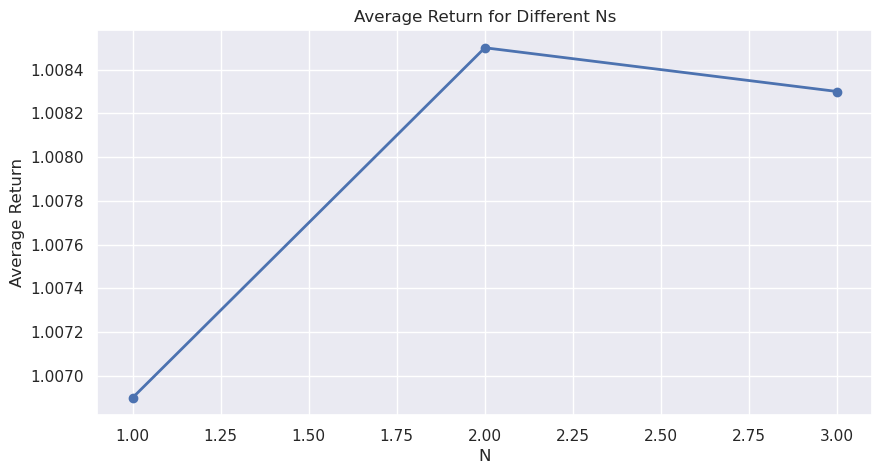

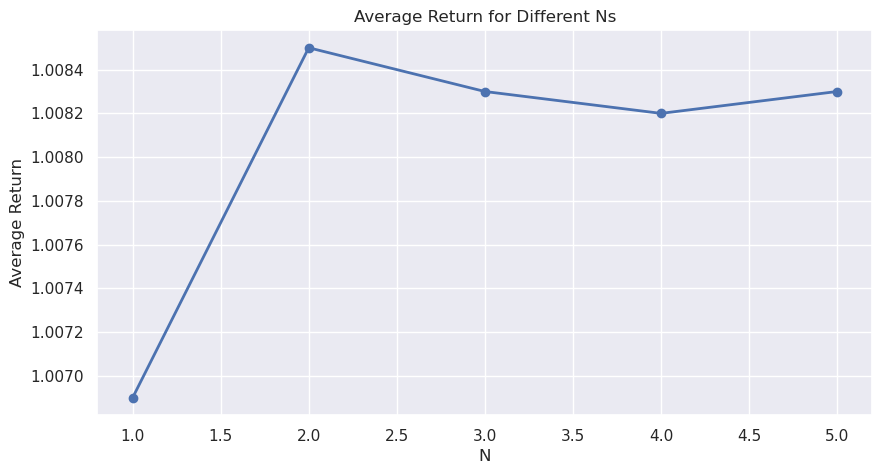

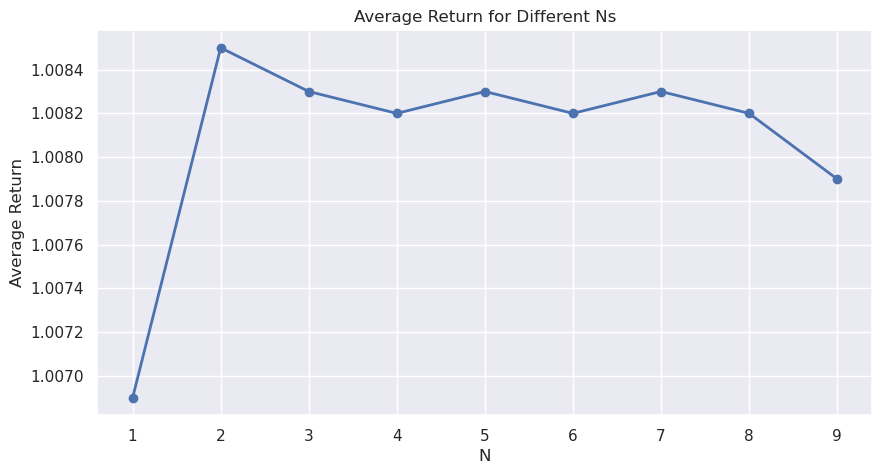

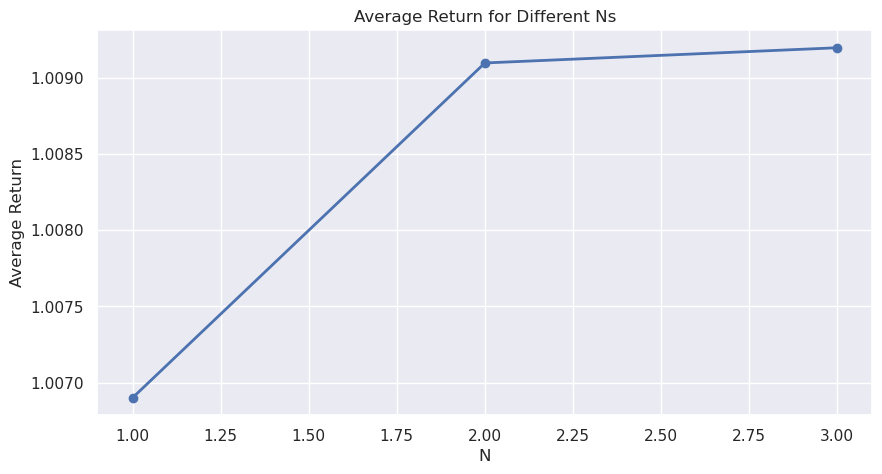

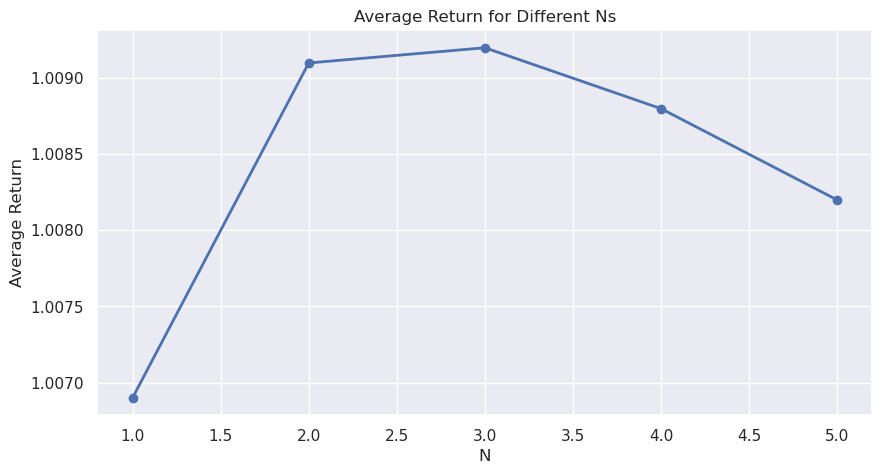

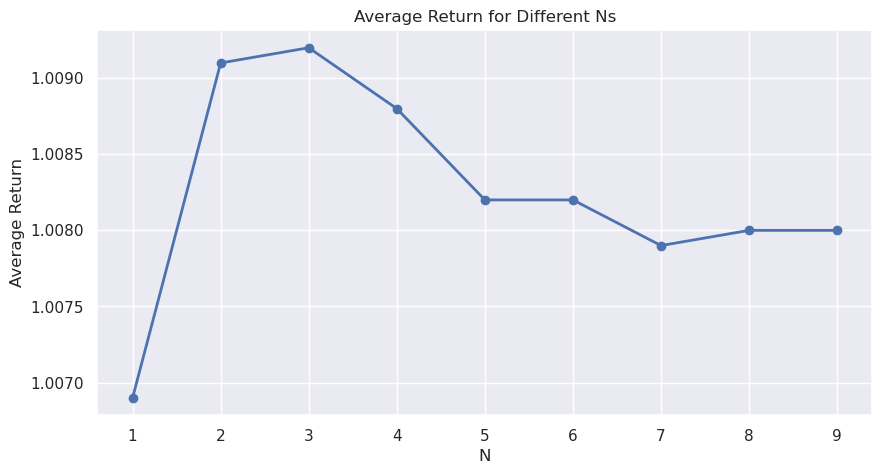

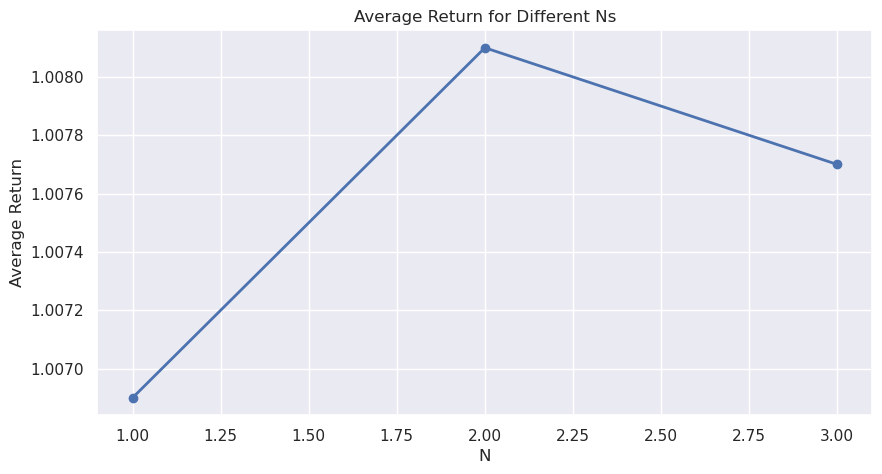

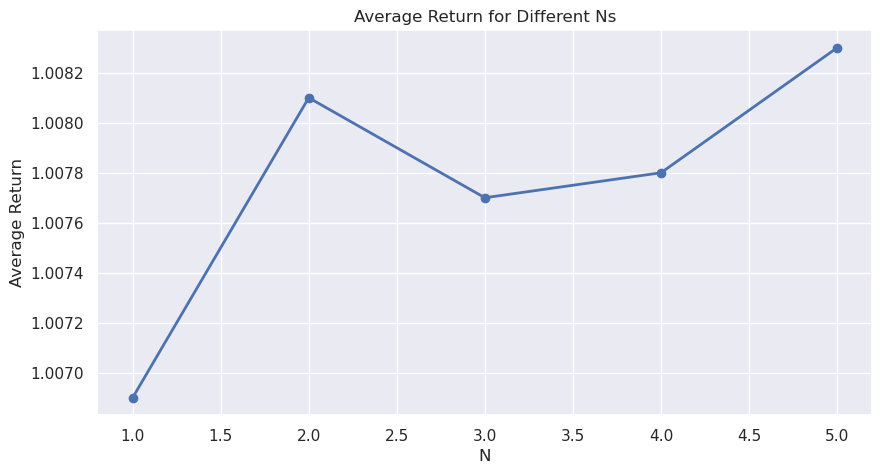

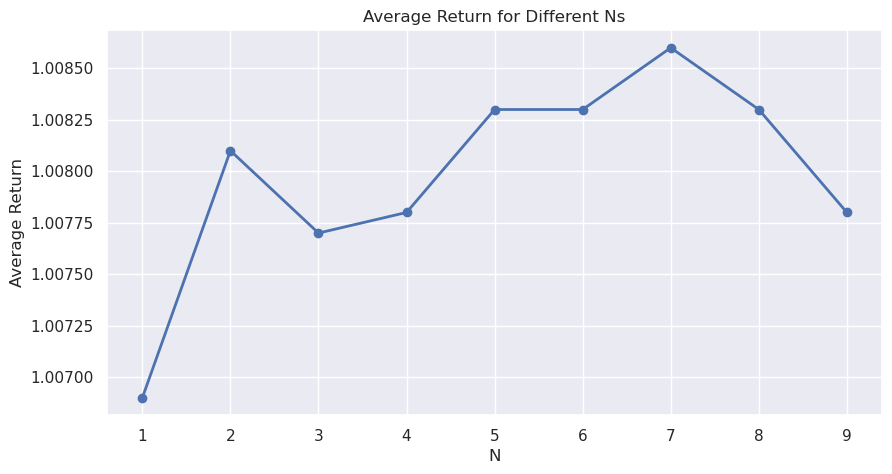

In [76]:
method = 'direct_log'
smooth_method = 'polynomial'
smooth_a = False
initial_folder_path = '../3-results/1-varying_smoothness/'

settings = ['pure', 'mixed']
smooth_parameters_pure = list(range(1, 21))
smooth_parameters_mixed = [1, 2, 3, 5, 10, 15, 20, 30, 50]
Ns = list(range(200)) + list(range(200,500, 10)) + list(range(500,2000, 100))
first_prints = [100, 200, 500, 2000]

for setting in settings:
    folder_path = initial_folder_path + setting + '/'
    if setting == 'pure':
        smooth_parameters = smooth_parameters_pure
    else:
        smooth_parameters = smooth_parameters_mixed

    for smooth_parameter in smooth_parameters:
        average_returns = []
        final_cumulative_returns = []
        a = estimate_a(df.weights_by_rank, smooth_method=smooth_method, smooth_parameter=smooth_parameter,  smooth_a=smooth_a)

        for N in Ns:
            strategy = compute_weights_optimal_open(setting=setting, N=N, a=a, weights_by_rank=df.weights_by_rank)
            backtest = Backtest(strategy=strategy, weights_permno_by_rank=df.weights_permno_by_rank, returns_by_permno=df.returns_by_permno)
            backtest.run()

            average_return = round(np.mean(backtest.rets), 4)
            final_cumulative_return = round(backtest.cumulative_rets[-1], 4)

            average_returns.append(average_return)
            final_cumulative_returns.append(final_cumulative_return)
            #print('N =', N, '. Average return:', average_return, '; Final Cumulative Return:', final_cumulative_return)
        
        new_folder = folder_path + 'smoothness='+str(smooth_parameter)+'/'
        os.makedirs(new_folder, exist_ok=True)
        for first_print in first_prints:
            plot_given_N(Ns, average_returns, first_print, new_folder, 'average_returns_'+str(first_print))

### Backtest log wealth

To backtest the log wealth I used the following formula:
$$
\log V = \pi^{\top} \frac {dX_t}{X_t} - \frac 1 2 \pi^{\top} d[X,X]\pi
$$

Which numerically translates to
$$
\log V_T = \sum_{t=0}^T \left [ \pi^{\top}(t) \frac {X_t - X_{t-1}}{X_{t-1}} - \sum_{i,j}\frac 1 2 \pi_i(t) d[X_i,X_j]\pi_j(t) \right] \\ 
d[X_i, X_j](t) = (X_i(t)-X_i(t-1)) (X_j(t)-X_j(t-1))
$$

In [6]:
backtest.compute_covariance_matrix()

In [7]:
term_1, term_2 = backtest.backtest_log_wealth()

           dot_product
mthcaldt              
1965-01-29         0.0
1965-02-26   -0.608308
              result
mthcaldt            
1965-01-29       0.0
1965-02-26  0.000645
[0.0, -0.6086308572317458, -1.298340032533542, -1.3064752566420088, -0.7611949117156047]
[0.0, -0.6086308572317458, -0.6897091753017961, -0.008135224108466895, 0.5452803449264041]


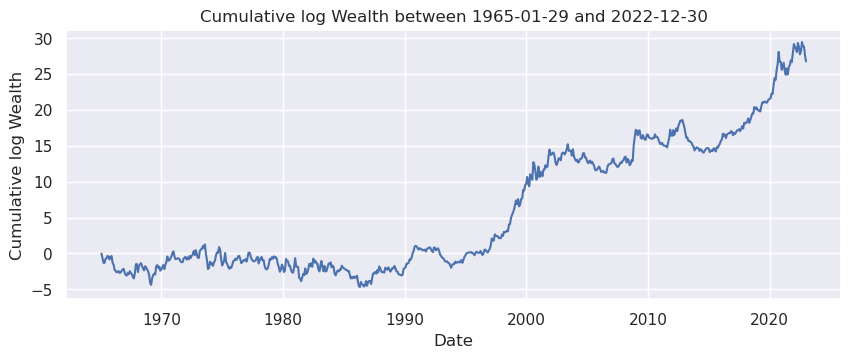

In [9]:
print(term_1.head(2))
print(term_2.head(2))
print(backtest.cumulative_log_wealths[0:5])
print(backtest.log_wealths[0:5])
backtest.plot_cumulative_log_wealth()